# Teste Técnico Birdie

@claudioalvesmonteiro
Junho, 2020

Abaixo pontuo as informações dadas para resolução do problema, bem como o passo-a-passo da análise que fiz. 

## Objetivos e informações de subsídio
1. Extração de aspectos: palavras dentro de um texto que codificam uma característica de seu funcionamento, estrutura, ou do processo de compra (entrega, SAC, consertos e problemas);
2. O quê está sendo falado nos canais de venda de seus produtos;
3. Encontrar uma maneira de extrair estes aspectos;
4. Explorar essas informações para gerar insights (por exemplo, quais aspectos estão mais relacionados com reviews positivos?);
5. Opcionalmente, criar gráficos e propostas de visualizações para suas observações;
6. Tópicos: NLP, named entity recognition, syntax pattern matching, feature extraction, topic representation, word embedding, sentence embedding

## Desenvolver e analisar

1. Pré-processar text e gerar tokens;
2. Contagem de palavras total para explorar aspectos;
3. Identificar os aspectos em cada comentário e salvar em variável;
4. Criar variável binária para avaliação, positivo > 3 estrelas e negativo < 2 estrelas;
5. Capturar bag of words (+ e -) para cada aspecto identificado;
6. Visualização wordcloud/wordcount para cada aspecto identificado; 
7. Volume de visualização por mes/semana e semana/horario-do-dia;
8. Tipo de geladeira _(breadcrumb)_ mais bem avaliados e mal avaliados por marca _(brand)_;
9. Comparar características _(specs_) das mais bem e mal avaliados;
10. Explorar tendência temporal das avaliações dos produtos (% positivas), line-plot and thick bar, por aspecto do produto;
12. relação com retailer (distribuidora) e brand (marca);
13. similaridade entre textos (?);
14. modelagem para ver o que influencia ter uma boa avaliação (?);


# Pré-processamento e Análise Exploratória

Com os objetivos definidos, o primeiro passo é pré-processar os comentários e colocar as palavras em caixa baixa, remover números, remover stopwords (conectivos) e aplicar o algoritmo lemmantization. Com isso padronizamos nosso texto para fazer uma extração de características mais eficiente. 

In [1]:
# import packages
import pandas as pd
import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [2]:
# import dataset
data = pd.read_csv('data/tech_test.tsv')

# % of duplicated reviews
print(round(sum(data.duplicated('review_id'))/len(data)*100, 2),'% de casos duplicados na base')

69.31 % de casos duplicados na base


Observando a estrutura dos dados pude observar que haviam reviews exatamente iguais mas apenas com momento de coleta diferentes, então acredito que isso seja resultado de algum processo na coleta dos dados. Como isso poderia gerar um viés na análise, já que vou executar a contagem de termos, decidi por excluir reviews com ID duplicado. 

In [3]:
# remove duplicated reviews
data = data.drop_duplicates('review_id')

In [4]:
def cleanTextToken(text, tokenization = True):
    ''' standardize text to extract words
    '''
    # text to lowercase
    text = text.lower()
    # remove numbers
    text = ''.join([i for i in text if not i.isdigit()]) 
    # remove punctuation
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+') # preserve words and alphanumeric
    text = tokenizer.tokenize(text)
    # remove stopwords
    from nltk.corpus import stopwords
    stop = set(stopwords.words('english'))
    text = [w for w in text if not w in stop] 
    # lemmatization
    from nltk.stem import WordNetLemmatizer 
    lemmatizer = WordNetLemmatizer() 
    text = [lemmatizer.lemmatize(word) for word in text]
    # return clean token
    return(text)

In [5]:
# generate variable with preprocessed text
data['review_body_token'] = [cleanTextToken(text) for text in data['review_body']]

Agora é possível fazer uma contagem dos termos mais frequentes e testar se é possível extrair aspectos a partir disso. Com um modelo pré-treinado do pacote nltk consigo extrair a classe gramatical de cada palavra (substantivo, adjetivo, pronome, etc.) e assim afunilar a busca por aspectos relevantes dos produtos em substantivos e posteriormente relacionar esses aspectos com a avaliação e com outras variáveis.

In [6]:
def wordCount(txt_list):
    ''' count frequency of words in tokenized list
        and save in dataframe
    '''
    wordfreq = {'word':[],'freq':[]}
    for word in txt_list:
        if word not in wordfreq['word']:
            wordfreq['word'].append(word)                   # save word
            wordfreq['freq'].append(txt_list.count(word))   # save freq
    count = pd.DataFrame(wordfreq)
    # sort_values in df
    count.sort_values('freq', inplace=True, ascending=False)
    return count

In [7]:
# combine all words in reviews
all_tokens = []
for comment in data['review_body_token']:
    for word in comment:
        all_tokens.append(word)

In [8]:
# contabilizar
all_count = wordCount(all_tokens[0:100000])

In [9]:
# funcao para identificar classe gramatical de palavras 
def nltkPerceptronClass(column):
    new_column =[]
    for word in column:
        new_column.append(nltk.pos_tag([word])[0][1])
    return new_column

In [10]:
# executar identifc de classe gramatical usando modelo pre-treinado da nltk
all_count['category'] = [nltk.pos_tag([word])[0][1] for word in all_count['word'] ]

In [11]:
all_count[0:20]

,word,freq,category
42,fridge,2473,NN
28,door,1823,NN
16,ice,1790,NN
102,refrigerator,1505,NN
47,part,1420,NN
45,review,1392,NN
36,freezer,1351,NN
37,love,1323,NN
48,promotion,1253,NN
46,collected,1252,VBN


Com base nessa análise exploratória é possível levantar palavras de relevância nos reviews, que podem servir como aspetos a serem analisados e cruzados com outras variáveis para compreender com mais detalhes as avaliações. Nessa etapa, entrar em contato com alguém da empresa que contratou o serviço, ou um especialista no produto, seria de muito valor para mostrar o resultado acima e explorar os aspectos. No caso, com base nos resultados, defini os termos abaixo como sendo de potencial interesse para o produto.

In [12]:
features = ['door',
            'ice',
            'refrigerator',
            'freezer',
            'promotion',
            'water',
            'space',
            'shelf',
            'dispenser',
            'time',
            'size',
            'problem',
            'price',
            'light',
            'temperature',
            'noise']

Abaixo segue a criação de variáveis para realizar o cruzamento das informações. É criada _review_aspects_, com aspectos presentes na review, _review_classification_. Uso o reconhecimento de classe gramatical do nltk para extrair adjetivos na review e fazer uma análise de sentimentos. Dessa forma é possível visualizar como os consumidores se sentem em relação a aspectos do produto como o a porta da geladeira, a luz, barulho, preço, espaço e etc.

In [13]:
def wordsInRow(words, token_row):
    ''' indentify if words is in list of tokens,
        return list with words intersected 
    '''
    new_row = []
    for word in words:
        if word in token_row:
            new_row.append(word)
    return new_row

In [14]:
# capture aspects in review
data['review_aspects'] = data['review_body_token'].apply(lambda row: wordsInRow(features, row)) 

In [15]:
# capture adjectives in review
adjectives = list(all_count['word'][all_count['category'] == 'JJ'])
data['review_adjectives'] = data['review_body_token'].apply(lambda row: wordsInRow(adjectives, row)) 

In [16]:
# review user binary classification
data['review_classification'] = [1 if x >= 4 else -1 for x in data['review_user_rating']]

In [17]:
# reset index
data.reset_index(inplace=True)

# Análise de Sentimentos

Agora é possível executar uma busca de termos e adjetivos próximos aos aspectos para compreender o que as pessoas estão falando em relação a cada aspecto. Destaco ainda que esse processo poderia ser direcionado a uma marca específica ou produto específico apenas implementando um simples filtro e comparando com outras marcas, tendo a marca cliente como referência.

In [18]:
def ruledSentimentTextAgg(token_list, category, rule='near'):
    ''' aggregate tokens in text following one,
        proximos a uma termo especifico.
        all: agg all tokens in list
        next: agg tokens next to the word
        near: agg tokens 2 words near
    '''
    text = ''
    for i in range(len(token_list)):
        if category in token_list[i]:
            row = token_list[i]
            cat_index = row.index(category)
            if rule == 'all':
                for word in row:
                    text = text + word + ' '  
            if rule == 'next':
                if cat_index > 0:
                    text += row[cat_index-1] + ' '
                if cat_index < (len(row)-1):
                    text += row[cat_index+1] + ' '
            if rule == 'near':
                count_id = 0
                while count_id < 3:
                    try:
                        word = row[cat_index+count_id]
                        if nltk.pos_tag([word])[0][1] == 'JJ':
                            text += word + ' '
                    except:
                        pass
                    count_id += 1
                count_id = 0    
                while count_id > -3:
                    try:
                        word = row[cat_index+count_id]
                        if nltk.pos_tag([word])[0][1] == 'JJ':
                            text += word + ' '
                    except:
                        pass
                    count_id -= 1
    return text

In [19]:
def wordcloudVisualization(text, max_words):
    %matplotlib inline
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    wordcloud = WordCloud(max_font_size=50, max_words=max_words, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [20]:
def aspectSentimentWordcloud(data, classification, aspect, max_words, rule='near'):
    data_posi = data[data['review_classification'] == classification].reset_index()
    text = ruledSentimentTextAgg(data_posi['review_body_token'], aspect, rule)
    wordcloudVisualization(text, max_words)

Agora podemos descer ao nível do aspecto, para compreender o que está relacionado a ele de maneira profunda. Abaixo é gerado (1) uma nuvem de palavras com termos ao lado do termo 'ice', na qual é possível identificar que se está relacionado ao componente de fazer gelo da geladeira; (2) uma nuvem de palavras com os termos próximos do termo 'ice' em avaliações positivas, em que se observa adjetivos relevantes como 'easy', 'big', 'spacious', 'large', que denotam um interesse dos consumidores sobre um produtor de gelo grande; por fim (3) a terceira nuvem de palavras captura termos próximos a 'ice' em avaliações negativas, aqui podemos observar o destaque dos adjetivos 'small' e 'tiny', o que reforça o interesse dos consumidores sobre um produtor de gelo grande, ao mesmo tempo também é possível ver termos positivos mesmo em avaliações ruins como 'good' e 'great'. Esse mesmo modelo de análise pode ser replicado para qualquer outro termo apenas mudando o 'aspect' nas funções.

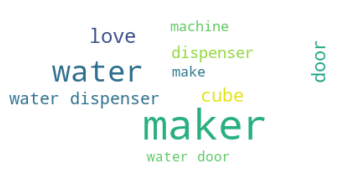

In [21]:
aspectSentimentWordcloud(data, classification=1, aspect='ice', max_words=10, rule='next')

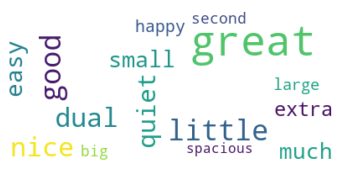

In [22]:
aspectSentimentWordcloud(data, classification=1, aspect='ice', max_words=15, rule='near')

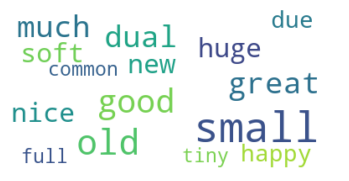

In [23]:
aspectSentimentWordcloud(data, classification=-1, aspect='ice', max_words=15, rule='near')

# Análise Temporal

Com os dados de data e hora do comentário é possível explorar a avaliação dos usuários e cruzar com termos e outras variáveis para saber se há uma variação temporal na percepção dos usuários sobre aspectos do produto ou a própria marca.

In [24]:
# transform day/month/year to week/month/year
data['date_month'] = pd.to_datetime(data['review_year'], format='%Y') + \
             pd.to_timedelta(data['review_week'].mul(7).astype(str) + ' days')

In [25]:
def aspectTimesSeries(df, token_column, aspect):
    ''' preprocess times series data for a specific category (aspect)
        in a column (token_column), generating positive porcent of reviews by week
    '''
    # select aspect data 
    data = df[df[token_column].apply(lambda x: aspect in x)]
    # crate dict to append results
    timeseries_positive = {'date':[],'positive_percent':[]}
    # loop through weks
    data['date_month'].unique()
    for date in data['date_month'].unique():
        # select date
        date_data = data[data['date_month'] == date]
        # calculate percent of positive reviews
        date_count = pd.DataFrame(date_data[['review_classification']].groupby('review_classification').size()).reset_index()
        date_count.columns=['review_classification', 'freq']
        date_count['percent'] = round(date_count['freq'] / sum(date_count['freq'] ) *100, 2)
        value = date_count['percent'][date_count['review_classification'] == 1]
        try:
            value = float(value)
        except:
            value = 0
        # save in dict
        timeseries_positive['positive_percent'].append(value)
        timeseries_positive['date'].append(date)
    # return df
    timeseries_positive = pd.DataFrame(timeseries_positive).sort_values('date')
    return timeseries_positive

In [26]:
def layoutLine(min, max):
    ''' define layout of line plot
        based on min and max entries for y axis
    '''
    import plotly.graph_objs as go
    layout = go.Layout( {'legend': {'bgcolor': '#F5F6F9', 'font': {'color': '#4D5663'}},
                   'paper_bgcolor': '#F5F6F9', 'plot_bgcolor': '#F5F6F9',
                   'title': {'font': {'color': '#4D5663'}},
                   'xaxis': {'gridcolor': '#E1E5ED', 'showgrid': True, 'tickfont': {'color': '#4D5663'},
                             'title': {'font': {'color': '#4D5663'}, 'text': ''}, 'zerolinecolor': '#E1E5ED'},
                   'yaxis': {'gridcolor': '#E1E5ED', 'range' : (min, max),'showgrid': True, 'tickfont': {'color': '#4D5663'},
                             'title': {'font': {'color': '#4D5663'}, 'text': ''}, 'zerolinecolor': '#E1E5ED'}})
    return layout

In [27]:
def timesSeriesVisualization(data, bestfit=True):
    # modules
    import plotly.graph_objs as go
    import plotly.offline as py
    from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
    import cufflinks as cf  
    # set notebook and offline config
    %matplotlib inline
    init_notebook_mode(connected=True)  
    cf.go_offline()
    # layout
    layout = layoutLine(0, 100)
    # visualization
    data.iplot(x = 'date',
               y='positive_percent' , 
               mode='lines+markers',
               size = 8,
               bestfit=bestfit,
               colors=['#87cded'],
               bestfit_colors=['pink'],
               layout=layout.to_plotly_json(),
               filename='test')

Nos gráficos abaixo é possível observar a porcentagem de reviews positivas relacionadas a um determinado aspecto ou categoria de uma variável (em azul), em conjunto com uma reta de regressão que sinaliza a tendência geral da distribuição. O _retailer_ "lowes" apresenta uma tendência positiva de avaliações enquanto "homedepot" apresenta uma tendência negativa. Entretanto vale salientar que essa tendência não aparenta ser muito expressiva, sendo necessário testes estatísticos ou modelos de séries temporais para capturar melhorar essa tendência, pois a variação mostrada pode ser aleatória. Se houvessem dados mais antigos poderíamos enxergar melhor uma tendência.

In [28]:
date_eval2 = aspectTimesSeries(data,token_column='retailer',aspect= 'lowes')
timesSeriesVisualization(date_eval2)

In [29]:
date_eval2 = aspectTimesSeries(data,token_column='retailer',aspect= 'homedepot')
timesSeriesVisualization(date_eval2)

Nesse sentido, uma possibilidade ainda seria analisar o efeito de uma intervenção na série temporal. Como por exemplo, uma marca poderia ter implementado uma campanha publicitária massiva a partir de determinada data e se tivéssemos os dados de avaliação antes e depois da intervenção seria possível executar um modelo de séries temporais interrompidas para testar o impacto da campanha nas avaliações.

É possível também explorar o volume de reviews por horário com base na variável  "review_collected_at", o que pode direcionar a empresa cliente a disponibilizar mais atendentes para responder essas reviews em horários de maior volume, ou ainda aumentar a capacidade do servidor do site em momentos específicos que se sabe que pode haver um pico de usuários. Vale salientar que esse processo preciaria ser validade com a equipe que construiu a base de dados para saber se o horário de coleta da review está de fato próxima do horário que ela foi postada.

In [30]:
# capture day and hour
data["review_collected_at"] = pd.to_datetime(data["review_collected_at"])
data['review_collect_week']= (data["review_collected_at"].dt.dayofweek)
data['review_collect_hour']= (data["review_collected_at"].dt.hour)

In [31]:
# size of reviews by day of week and hour
date_volume = pd.DataFrame(data[['review_collect_week','review_collect_hour']].
 groupby(['review_collect_week','review_collect_hour']).size()).reset_index()

# rename columns
date_volume.columns = ['review_collect_week','review_collect_hour','freq']

# subtitue 0 by 24 and remove 24 from day of week
date_volume[date_volume['review_collect_hour'] == 0] = 24
date_volume[date_volume['review_collect_week']==24] =0

<Figure size 432x288 with 0 Axes>

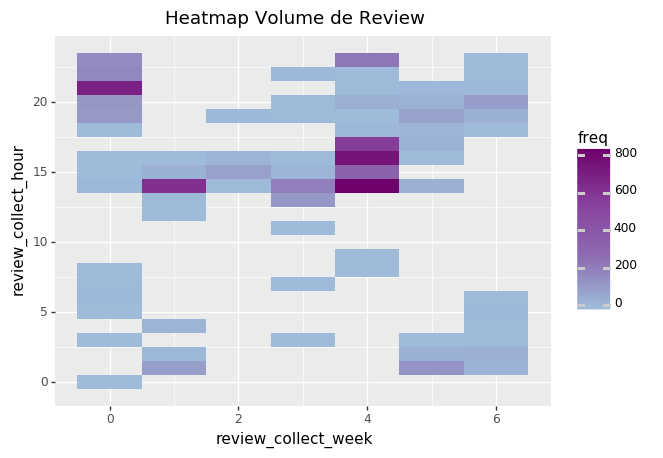

<ggplot: (-9223371873760427708)>

In [32]:
from plotnine import * 
import matplotlib.pyplot as plt
fig = plt.figure()

ggplot(date_volume, aes('review_collect_week', 'review_collect_hour')) + geom_tile(aes(fill='freq'))\
    + scale_fill_gradientn(colors=['#9ebcda','#8c6bb1','#88419d','#6e016b']) \
    + ggtitle("Heatmap Volume de Review")